# Proyecto Final
## Oscar Chavez


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

## Clase

In [103]:
class regressions():
    def __init__(self, seleccion):
        data=np.load('proyecto_training_data.npy')
        entrenamiento = data[0: int(len(data) * .8)]
        validacion = data[int(len(data) * .8):len(data)]
        self.df1 = pd.DataFrame(data, columns=['SalePrice', 'OverallQual', '1stFlrSF', 'TotRmsAbvGrd', 'YearBuilt', 'LotFrontage'])

        corr_list=self.df1.corr()['SalePrice']#.tail(5)
        selected_var = corr_list.tail(5).sort_values(ascending=False).head(2).index
        if seleccion == 1:
            self.name = selected_var[0]
            print("La variable seleccionada es: {}".format(selected_var[0]))
            self.xentrenamiento=entrenamiento[:,1].reshape(-1, 1)
            self.xvalidacion=validacion[:,1].reshape(-1, 1)
        else:
            self.name = selected_var[1]
            print("La variable seleccionada es: {}".format(selected_var[1]))
            self.xentrenamiento=entrenamiento[:,2].reshape(-1, 1)  
            self.xvalidacion=validacion[:,2].reshape(-1, 1)  
        
        self.betas = np.array([[0],[0]])
        self.yentrenamiento = entrenamiento[:,0].reshape(-1, 1)
        self.yvalidacion = validacion[:,0].reshape(-1, 1)

    def EDA(self):
        cols = self.df1.columns
        print(self.df1.describe())
        print("\nrango")
        print(self.df1.max()-self.df1.min())

        for col in cols:
            sns.displot(self.df1[col])
        corr_list=self.df1.corr()['SalePrice']#.tail(5)
        for col in cols:
            plt.title('Correlacion entre Sale Prices y {},\ncoeficiente = {}'.format(col,corr_list[col]),y=1.05)
            plt.xlabel(col)
            plt.ylabel('SalePrice')
            plt.scatter(self.df1[col],self.df1['SalePrice'])
#            plt.xlim([df1[col].min(),df1[col].max()])
            plt.show()
        print("La variable seleccionada es: {}".format(self.name))
      
    def entrenar_mod_manual(self,epochs, imprimir_error_cada, lrate):  
        x = self.xentrenamiento
        y = self.yentrenamiento
        vect1 = np.ones_like(x).reshape(-1, 1)
        x1 = np.hstack([x, vect1])
        error = 0
        error_list = []
        B_dic = {}
        for aux in range (1, epochs+1):
            yhat = np.matmul(x1, self.betas)
            #print("yhat")
            #print(yhat)
            error = y - yhat
            #print('y-yhat')
            #print(error)
            error = np.power(error,2)
            error = error.sum()
            error = error / (len(y))
            error_list.append(error)
            if(aux ==1):  # Comentar si no se quiere ver la primera iteracion
                print('Primera iteracion')
                print('Error: {0:,}'.format(error))
            if (aux % imprimir_error_cada == 0):
                print('Iteracion: {}'.format(aux))
                print('Error: {0:,}'.format(error))
            GEB = y - yhat
            GEB = GEB*x1
            #print('GEB * x1')
            #print(GEB)
            GEB = GEB.sum(axis=0)
            GEB = (-2) * GEB / len(x)

            #print('betas old')
            #print(betas)
            self.betas = self.betas - lrate * GEB.reshape(-1,1)
            B_dic[aux] = self.betas
            #print('betas new')
            #print(betas)
            #print("")
        return error_list, B_dic
    
    def entrenar_mod_auto(self):
        lm = LinearRegression()
        lm.fit(self.xentrenamiento,self.yentrenamiento)
        return lm.coef_, lm.intercept_
       
    def vis_error(self, errores):
        plt.plot(errores, color='r')
        plt.title("Error en cada iteracion")
        plt.xlabel("Iteracion")
        plt.ylabel("Error");
        plt.xlim([-10, 500])
    
    def vis_modelo(self,param,n):
        subs = []
        subs.append(1)   # Comentar si no se quiere ver la primera aproximacion 
        for aux in range(1,len(param)+1):
            if(aux % n)==0:
                subs.append(aux)
        new_param=dict((k, param[k]) for k in subs)
       # print(subs)
        plt.scatter(self.df1[self.name],self.df1['SalePrice'])
        for aux in subs:
            x = np.linspace(self.df1[self.name].min(),self.df1[self.name].max(),100)
            y = new_param[aux][0].sum()*x+new_param[aux][1].sum()
            plt.plot(x, y, '-r', label=str(aux))

            plt.title('Aproximacion del modelo manual')
            plt.xlabel('x', color='#1C2833')
            plt.ylabel('y', color='#1C2833')
            #plt.legend(loc='upper left')
            plt.grid()
            #plt.show()
    def predecir(self, x, betas_auto, graph):
        betas_auto = np.array([[betas_auto[0].sum()],[betas_auto[1].sum()]])
        betas_prom = np.array([[(betas_auto[0].sum()+self.betas[0].sum())/2],[(betas_auto[1].sum()+self.betas[1].sum())/2]])
        vect1 = np.ones_like(x).reshape(-1, 1)
        x = np.hstack([x, vect1])
        pred_manual = np.matmul(x, self.betas)
        pred_auto = np.matmul(x, betas_auto)
        pred_prom = np.matmul(x, betas_prom)
        print("Betas con el modelo entrenado manualmente:")
        print(self.betas)
        print("Betas con el modelo de scikit-learn")
        print(betas_auto)
        print("Betas promediadas")
        print(betas_prom)
        if graph == 1:
            plt.scatter(self.df1[self.name],self.df1['SalePrice'])
            
            x = np.linspace(self.df1[self.name].min(),self.df1[self.name].max(),100)
            y = self.betas[0].sum()*x+self.betas[1].sum()
            plt.plot(x, y, '-r', label='manual')

            x1 = np.linspace(self.df1[self.name].min(),self.df1[self.name].max(),100)
            y1 = betas_auto[0].sum()*x+betas_auto[1].sum()
            plt.plot(x1, y1, '-b', label='auto')         
           
            x2 = np.linspace(self.df1[self.name].min(),self.df1[self.name].max(),100)
            y2 = betas_prom[0].sum()*x+betas_prom[1].sum()
            plt.plot(x2, y2, '-y', label='promedio')

            plt.title('Comparacion de la aproximacion de cada modelo')
            plt.xlabel('x', color='#1C2833')
            plt.ylabel('y', color='#1C2833')
            plt.legend(loc='upper left')
            plt.grid()
            #plt.show()
        return pred_manual, pred_auto, pred_prom
    def validar(self, betas_auto, graph):
        predict = self.predecir(self.xvalidacion, betas_auto,graph)
        errorM = self.yvalidacion - predict[0]
        errorM = np.power(errorM,2)
        errorM = errorM.sum()
        errorM = errorM / (len(predict[0]))
        
        errorA = self.yvalidacion - predict[1]
        errorA = np.power(errorA,2)
        errorA = errorA.sum()
        errorA = errorA / (len(predict[1]))
        
        errorP = self.yvalidacion - predict[2]
        errorP = np.power(errorP,2)
        errorP = errorP.sum()
        errorP = errorP / (len(predict[2]))
        
        x = ['Manual', 'scikit-learn', 'Promedio']
        y = [errorM, errorA, errorP]
        
        fig, ax = plt.subplots(figsize=(20,4))
        bars = ax.bar(x, y, width=0.5)
        fig.suptitle('Errores con los diferentes modelos', fontsize=16)

        for bar in bars:
          height = bar.get_height()
          label_x_pos = bar.get_x() + bar.get_width() / 2
          ax.text(label_x_pos, height, s=f'{height}', ha='center',
          va='bottom')
        return  x[y.index(min(y))]
        

## Ejemplo con variable independiente 2

In [104]:
test1 = regressions(1)

La variable seleccionada es: OverallQual


           SalePrice  OverallQual     1stFlrSF  TotRmsAbvGrd    YearBuilt  \
count    1460.000000  1460.000000  1460.000000   1460.000000  1460.000000   
mean   180921.195890     6.099315  1162.626712      6.517808  1971.267808   
std     79442.502883     1.382997   386.587738      1.625393    30.202904   
min     34900.000000     1.000000   334.000000      2.000000  1872.000000   
25%    129975.000000     5.000000   882.000000      5.000000  1954.000000   
50%    163000.000000     6.000000  1087.000000      6.000000  1973.000000   
75%    214000.000000     7.000000  1391.250000      7.000000  2000.000000   
max    755000.000000    10.000000  4692.000000     14.000000  2010.000000   

       LotFrontage  
count  1201.000000  
mean     70.049958  
std      24.284752  
min      21.000000  
25%      59.000000  
50%      69.000000  
75%      80.000000  
max     313.000000  

rango
SalePrice       720100.0
OverallQual          9.0
1stFlrSF          4358.0
TotRmsAbvGrd        12.0
YearBuilt 

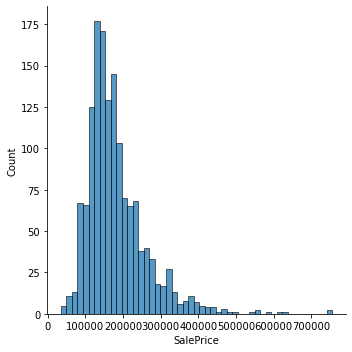

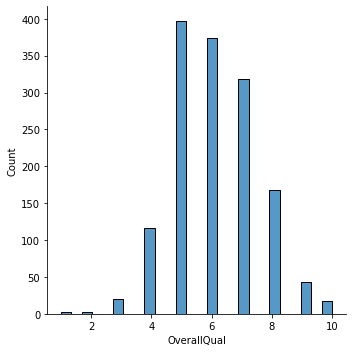

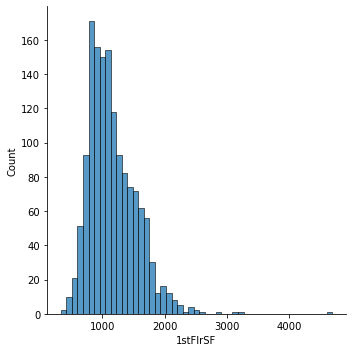

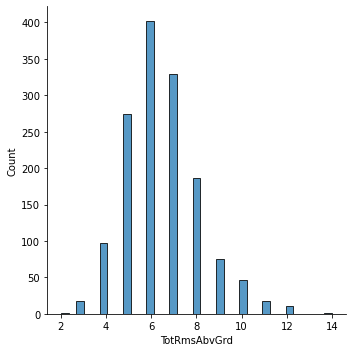

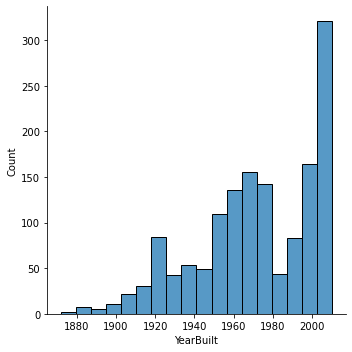

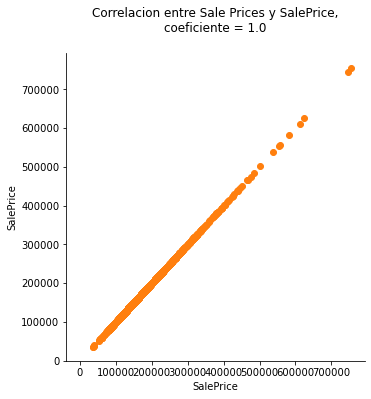

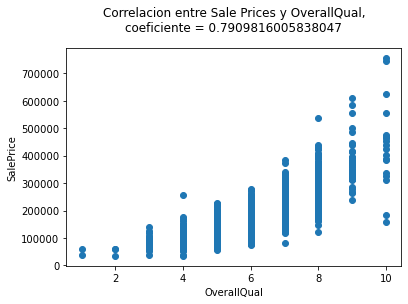

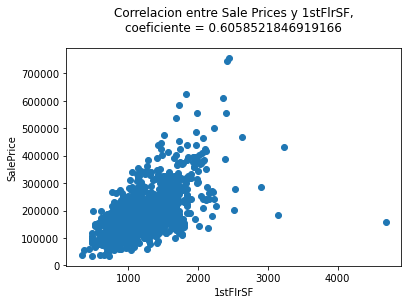

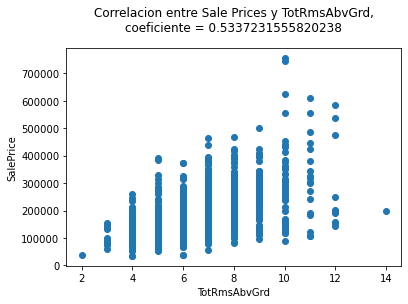

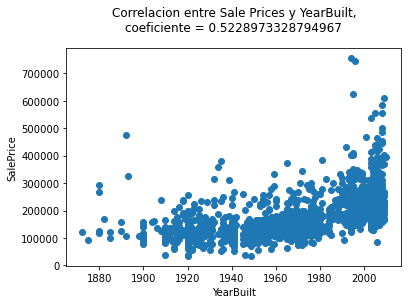

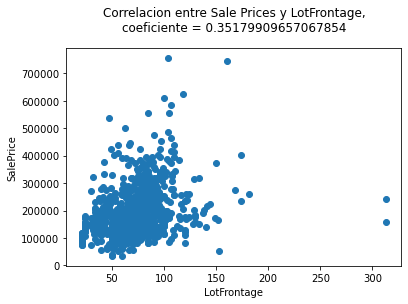

La variable seleccionada es: OverallQual


In [125]:
test1.EDA()

In [106]:
A = test1.entrenar_mod_manual(200000, 50000, 0.0002)
#A = test1.entrenar_mod_manual(10000, 1000, 0.01)
errores = A[0]
param = A[1]

Primera iteracion
Error: 38,819,444,106.4435
Iteracion: 1000
Error: 2,368,502,667.629051
Iteracion: 2000
Error: 2,305,059,083.1866546
Iteracion: 3000
Error: 2,295,520,361.181565
Iteracion: 4000
Error: 2,294,086,217.472787
Iteracion: 5000
Error: 2,293,870,594.438975
Iteracion: 6000
Error: 2,293,838,175.5869274
Iteracion: 7000
Error: 2,293,833,301.4232097
Iteracion: 8000
Error: 2,293,832,568.594302
Iteracion: 9000
Error: 2,293,832,458.4137177
Iteracion: 10000
Error: 2,293,832,441.848102


In [107]:
test1.betas

array([[ 45410.78601519],
       [-96461.8044729 ]])

In [108]:
param[200000]

KeyError: 200000

In [109]:
test1.entrenar_mod_auto()

(array([[45411.99877916]]), array([-96469.57131874]))

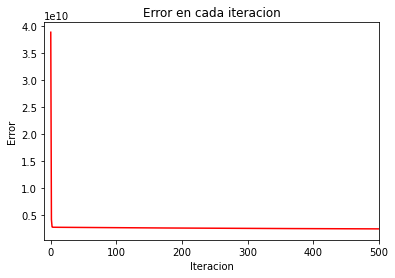

In [110]:
test1.vis_error(errores)

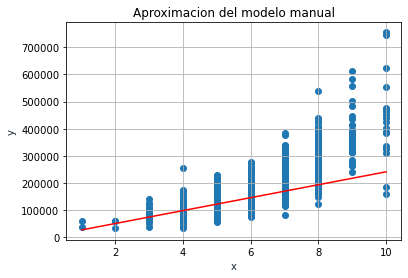

In [111]:
test1.vis_modelo(param,15000)

In [112]:
a=np.array([[1],[2],[3],[4]])
prueba = test1.predecir(a,test1.entrenar_mod_auto(),0)
prueba

Betas con el modelo entrenado manualmente:
[[ 45410.78601519]
 [-96461.8044729 ]]
Betas con el modelo de scikit-learn
[[ 45411.99877916]
 [-96469.57131874]]
Betas promediadas
[[ 45411.39239717]
 [-96465.68789582]]


(array([[-51051.01845772],
        [ -5640.23244253],
        [ 39770.55357266],
        [ 85181.33958785]]),
 array([[-51057.57253958],
        [ -5645.57376042],
        [ 39766.42501874],
        [ 85178.4237979 ]]),
 array([[-51054.29549865],
        [ -5642.90310147],
        [ 39768.4892957 ],
        [ 85179.88169287]]))

Betas con el modelo entrenado manualmente:
[[ 45410.78601519]
 [-96461.8044729 ]]
Betas con el modelo de scikit-learn
[[ 45411.99877916]
 [-96469.57131874]]
Betas promediadas
[[ 45411.39239717]
 [-96465.68789582]]


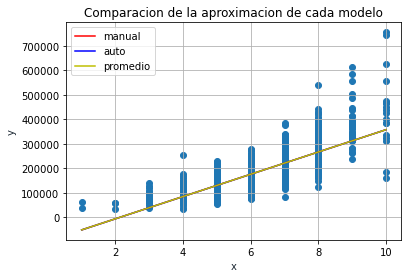

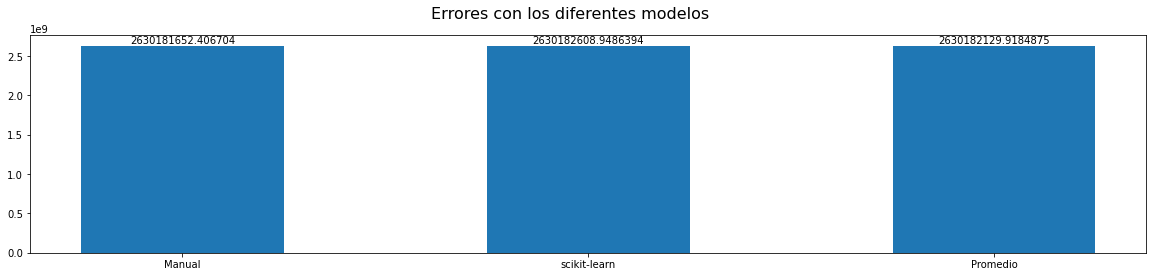

In [114]:
best = test1.validar(test1.entrenar_mod_auto(),1)

In [115]:
print('El modelo con el error más pequeño, y por ende el mejor modelo para la variable {} es:'.format(test1.name))
print(best)

El modelo con el error más pequeño, y por ende el mejor modelo para la variable OverallQual es:
Manual


## Ejemplo con variable independiente 2

In [116]:
test2 = regressions(2)

La variable seleccionada es: 1stFlrSF


In [117]:
test2.betas

array([[0],
       [0]])

In [118]:
B = test2.entrenar_mod_manual(200000,50000,0.0000001)
errores2 = B[0]
param2 = B[1]

Primera iteracion
Error: 38,819,444,106.4435
Iteracion: 50000
Error: 3,936,021,982.668646
Iteracion: 100000
Error: 3,935,858,098.969803
Iteracion: 150000
Error: 3,935,694,524.8208494
Iteracion: 200000
Error: 3,935,531,259.637095


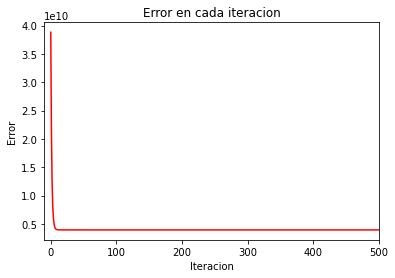

In [119]:
test2.vis_error(errores2)

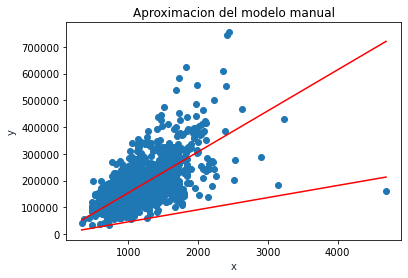

In [120]:
test2.vis_modelo(param2,200000) # mas pequeño el numero para mas lineas

In [121]:
test2.entrenar_mod_auto()

(array([[129.95124229]]), array([30324.58517496]))

In [122]:
test2.betas

array([[153.60744522],
       [114.56821661]])

In [123]:
a2=np.array([[1],[2],[3]])
prueba2 = test2.predecir(a2,test2.entrenar_mod_auto(),0)
prueba2

Betas con el modelo entrenado manualmente:
[[153.60744522]
 [114.56821661]]
Betas con el modelo de scikit-learn
[[  129.95124229]
 [30324.58517496]]
Betas promediadas
[[  141.77934376]
 [15219.57669579]]


(array([[268.17566183],
        [421.78310706],
        [575.39055228]]),
 array([[30454.53641725],
        [30584.48765954],
        [30714.43890183]]),
 array([[15361.35603954],
        [15503.1353833 ],
        [15644.91472705]]))

Betas con el modelo entrenado manualmente:
[[153.60744522]
 [114.56821661]]
Betas con el modelo de scikit-learn
[[  129.95124229]
 [30324.58517496]]
Betas promediadas
[[  141.77934376]
 [15219.57669579]]


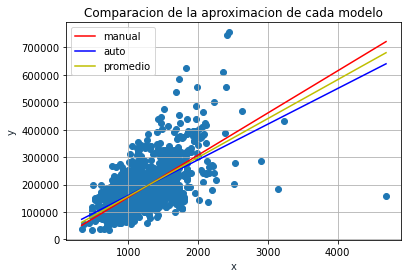

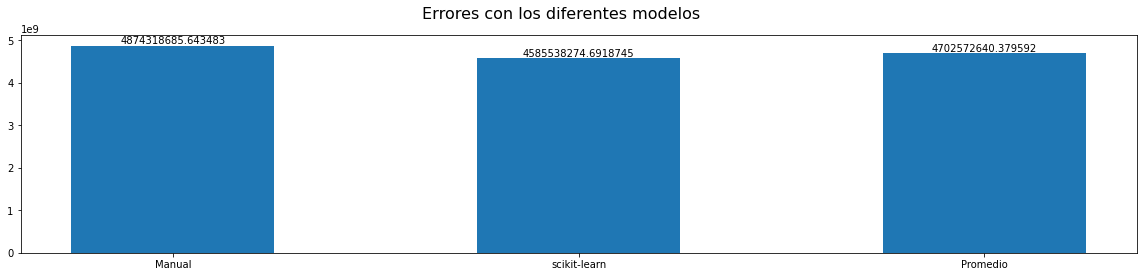

In [124]:
best2 = test2.validar(test2.entrenar_mod_auto(),1)

In [ ]:
print('El modelo con el error más pequeño, y por ende el mejor modelo para la variable {} es:'.format(test2.name))
print(best2)

# -- FIN --